In [1]:
import pandas as pd

file_path = "CICIDS2018.csv"  
df = pd.read_csv(file_path, low_memory=False)

# Display basic info
print(df.shape)
df.head()



(8392401, 14)


,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,172.31.66.17,51128,23.36.69.189,443,6,91.000,152,0,3,0,194,4285680,0,Benign
1,34.195.59.178,443,172.31.66.17,51036,6,91.178,994,979,7,7,24,4234714,0,Benign
2,112.215.171.212,12262,172.31.66.17,445,6,0.000,585,344,5,4,30,4294106,0,Benign
3,172.31.66.17,61023,172.31.0.2,53,17,0.000,136,168,2,2,0,4293985,0,Benign
4,34.204.112.168,443,172.31.66.17,51037,6,91.178,72,40,1,1,24,4294845,0,Benign


In [2]:
!pip install xgboost


Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Show only columns with missing values
print(missing_values)


Series([], dtype: int64)


In [4]:
# Drop IP address columns
columns_to_drop = ['IPV4_SRC_ADDR', 'IPV4_DST_ADDR']
df.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')

# Display updated dataset info
print(df.dtypes)


L4_SRC_PORT                     int64
L4_DST_PORT                     int64
PROTOCOL                        int64
L7_PROTO                      float64
IN_BYTES                        int64
OUT_BYTES                       int64
IN_PKTS                         int64
OUT_PKTS                        int64
TCP_FLAGS                       int64
FLOW_DURATION_MILLISECONDS      int64
Label                           int64
Attack                         object
dtype: object


In [5]:
from sklearn.preprocessing import LabelEncoder

# Encode the Attack column
label_encoder = LabelEncoder()
df['Attack'] = label_encoder.fit_transform(df['Attack'])

# Show label mapping
attack_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Attack Mapping:", attack_mapping)

# Verify data types
print(df.dtypes)



Attack Mapping: {'Benign': 0, 'Bot': 1, 'Brute Force -Web': 2, 'Brute Force -XSS': 3, 'DDOS attack-HOIC': 4, 'DDOS attack-LOIC-UDP': 5, 'DDoS attacks-LOIC-HTTP': 6, 'DoS attacks-GoldenEye': 7, 'DoS attacks-Hulk': 8, 'DoS attacks-SlowHTTPTest': 9, 'DoS attacks-Slowloris': 10, 'FTP-BruteForce': 11, 'Infilteration': 12, 'SQL Injection': 13, 'SSH-Bruteforce': 14}
L4_SRC_PORT                     int64
L4_DST_PORT                     int64
PROTOCOL                        int64
L7_PROTO                      float64
IN_BYTES                        int64
OUT_BYTES                       int64
IN_PKTS                         int64
OUT_PKTS                        int64
TCP_FLAGS                       int64
FLOW_DURATION_MILLISECONDS      int64
Label                           int64
Attack                          int32
dtype: object


In [6]:

df_sampled = df.groupby('Attack', group_keys=False).apply(lambda x: x.sample(n=min(len(x), 5000), random_state=42))



In [7]:
from sklearn.model_selection import train_test_split

# Separate features and labels
X = df_sampled.drop(columns=['Label'])  # Drop the label column
y = df_sampled['Label']  # Target variable

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print new dataset shapes
print("New Training Set Shape:", X_train.shape, y_train.shape)
print("New Testing Set Shape:", X_test.shape, y_test.shape)


New Training Set Shape: (45032, 11) (45032,)
New Testing Set Shape: (11259, 11) (11259,)


In [8]:
important_features = ['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'IN_BYTES', 
                      'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS']

X_train = X_train[important_features]
X_test = X_test[important_features]


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)  # Reduced complexity
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))






Random Forest Accuracy: 0.95603517186251
              precision    recall  f1-score   support

           0       0.87      0.60      0.71      1000
           1       0.96      0.99      0.98     10259

    accuracy                           0.96     11259
   macro avg       0.91      0.79      0.84     11259
weighted avg       0.95      0.96      0.95     11259



In [10]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=50, learning_rate=0.05, max_depth=6, reg_lambda=1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.9528377298161471
              precision    recall  f1-score   support

           0       0.87      0.56      0.68      1000
           1       0.96      0.99      0.97     10259

    accuracy                           0.95     11259
   macro avg       0.91      0.77      0.83     11259
weighted avg       0.95      0.95      0.95     11259



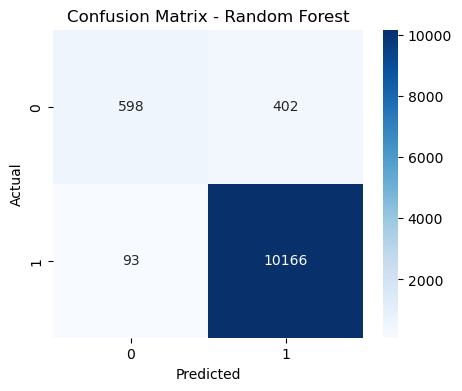

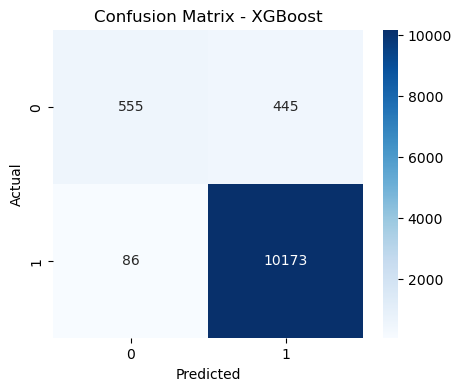

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

models = {'Random Forest': y_pred_rf, 'XGBoost': y_pred_xgb}

for model_name, y_pred in models.items():
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [12]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [6, 10, 15], 
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best Random Forest Parameters:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_


Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}


In [13]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

rand_xgb = RandomizedSearchCV(XGBClassifier(random_state=42), param_distributions=param_dist_xgb, 
                              n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
rand_xgb.fit(X_train, y_train)

print("Best XGBoost Parameters:", rand_xgb.best_params_)
best_xgb = rand_xgb.best_estimator_


Best XGBoost Parameters: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 0.7}


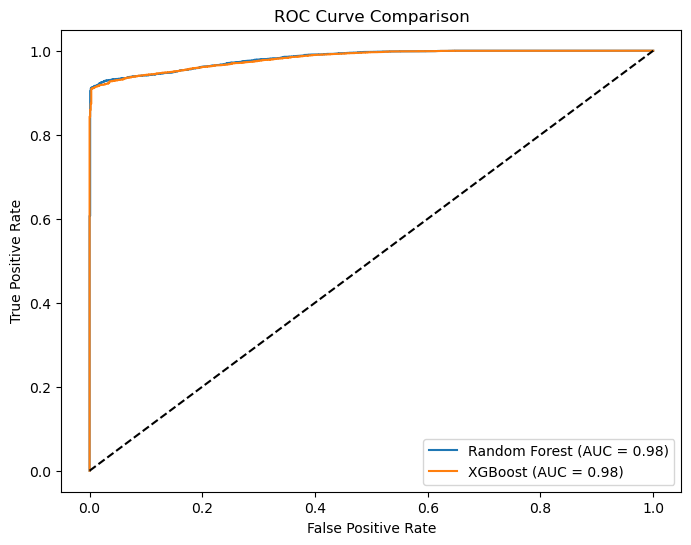

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

models = {'Random Forest': best_rf, 'XGBoost': best_xgb}

plt.figure(figsize=(8,6))
for model_name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Random performance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [15]:
!pip install shap


Defaulting to user installation because normal site-packages is not writeable


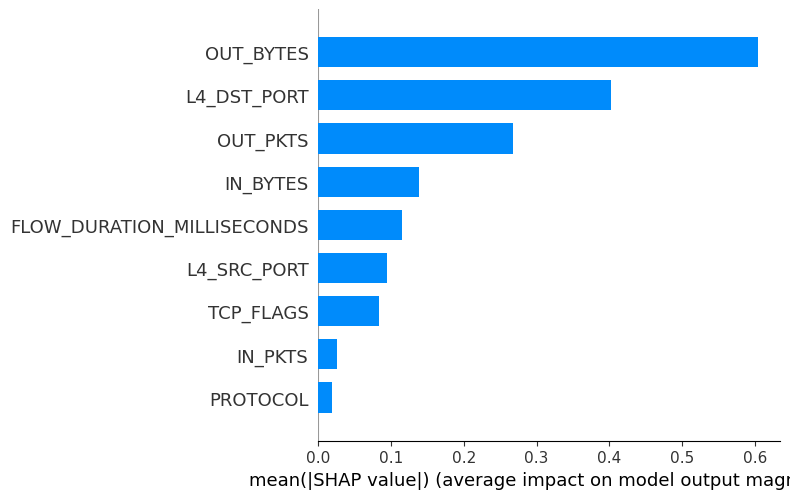

In [16]:
import shap

explainer = shap.Explainer(best_xgb)  # Using XGBoost for SHAP
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")


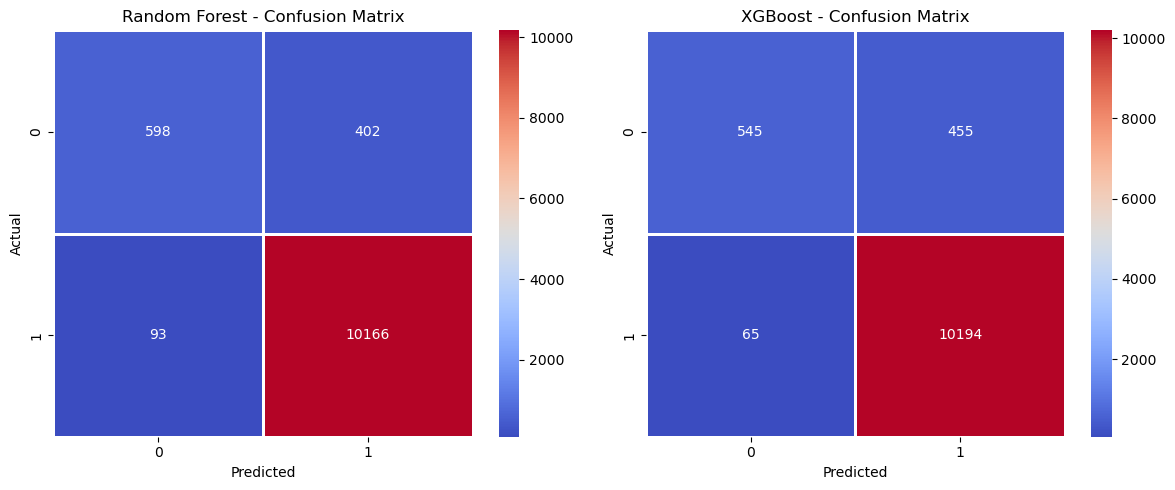

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

models = {'Random Forest': best_rf, 'XGBoost': best_xgb}

plt.figure(figsize=(12, 5))

for i, (name, model) in enumerate(models.items()):
    plt.subplot(1, 2, i+1)
    conf_matrix = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", linewidths=1)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")

plt.tight_layout()
plt.show()
